In [3]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
PATH = "./kaggle/input/digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [5]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [6]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define class MNIST
I'll define `class MNIST` which was inherited `torch.utils.data.Dataset`.

In [7]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        

In [10]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [11]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

## Define TripletLoss

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Neural Network

In [15]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

### weight initialize

In [16]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

### Create Instances
Use JIT compilation for high speed.

In [17]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

## Training Loop

In [18]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.2292


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.0930


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.0750


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0658


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0565


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0519


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0490


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0439


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0413


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0394


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.0358


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0366


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0354


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.0355


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0327


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0308


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0304


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0296


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0302


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0279


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0284


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.0286


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0260


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0235


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0272


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0277


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.0243


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.0229


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.0236


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.0231


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0247


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0239


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0230


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0207


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0219


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0213


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0226


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0206


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0238


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0206


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0183


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0206


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0214


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0203


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0192


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0205


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0198


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0202


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0179


Training:   0%|          | 0/1313 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0183


## Save Params

In [19]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

In [20]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/1313 [00:00<?, ?it/s]

(42000, 2)

## Visualization 

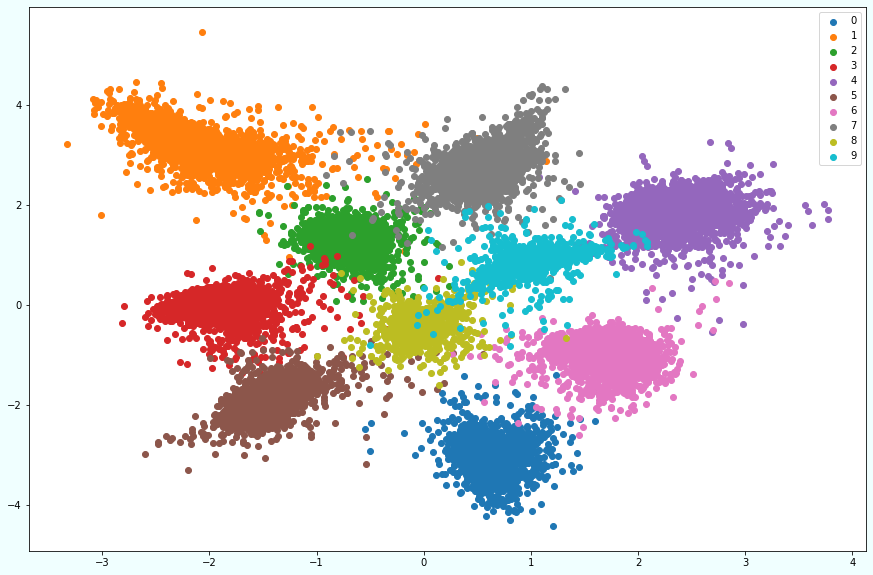

In [21]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

## Training XGBoost Model

In [ ]:
tree = XGBClassifier(seed=2020)
tree.fit(train_results, labels)

In [ ]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(test_loader):
        test_results.append(model(img.to(device)).cpu().numpy())
        
test_results = np.concatenate(test_results)

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1], label=label)

test_results.shape

## Submit

In [ ]:
submit = pd.read_csv(PATH+"sample_submission.csv")
submit.Label = tree.predict(test_results)

submit.head()

In [ ]:
submit.to_csv("submission.csv", index=False)